In [2]:
import math
import re
import glob
import os
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell
import scipy.interpolate as interpolate
import matplotlib.pylab as pylab

m = 9.10938356e-31       # kg
M = 6.63352136e-26       # kg
T = 87                   # K
k_b = 1.38064852e-23     # J/K

a_ar = sqrt(k_b * T / M) # m/s
a_el = sqrt(k_b * T / m) # m/s

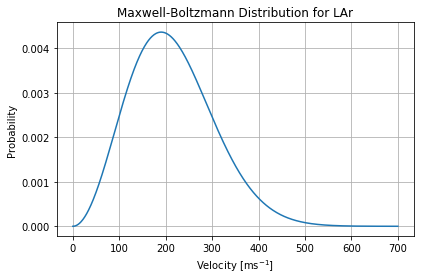

In [5]:
# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

x_vals = np.linspace(0, 700, 701)

plt.plot(x_vals, maxwell.pdf(x_vals, scale=a_ar))

plt.xlabel('Velocity [ms$^{-1}$]')
plt.ylabel('Probability')
plt.title('Maxwell-Boltzmann Distribution for LAr')

plt.grid()
plt.tight_layout()
plt.show()

# plt.savefig(f'../documentation/images/mb_dist_lar.pdf', bbox_inches='tight')

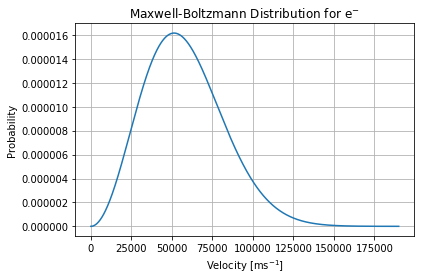

In [6]:
# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

x_vals = np.linspace(0, 190000, num=190001)

plt.plot(x_vals, maxwell.pdf(x_vals, scale=a_el))

plt.xlabel('Velocity [ms$^{-1}$]')
plt.ylabel('Probability')
plt.title('Maxwell-Boltzmann Distribution for e$^{-}$')

plt.grid()
plt.tight_layout()
plt.show()

# plt.savefig(f'../documentation/images/mb_dist_e.pdf', bbox_inches='tight')

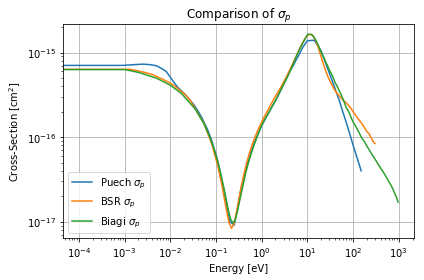

In [7]:
# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

pue_x, pue_y = np.loadtxt('puech.txt', unpack=True)
bsr_x, bsr_y = np.loadtxt('bsr.txt', unpack=True)
bia_x, bia_y = np.loadtxt('biagi.txt', unpack=True)

plt.plot(pue_x, pue_y * 1e4, label='Puech $\sigma_p$')
plt.plot(bsr_x, bsr_y * 1e4, label='BSR $\sigma_p$')
plt.plot(bia_x, bia_y * 1e4, label='Biagi $\sigma_p$')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('Cross-Section [cm$^2$]')
plt.xlabel('Energy [eV]')
plt.title('Comparison of $\sigma_p$')

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# plt.savefig('sigma_p_comparison.pdf', bbox_inches='tight')

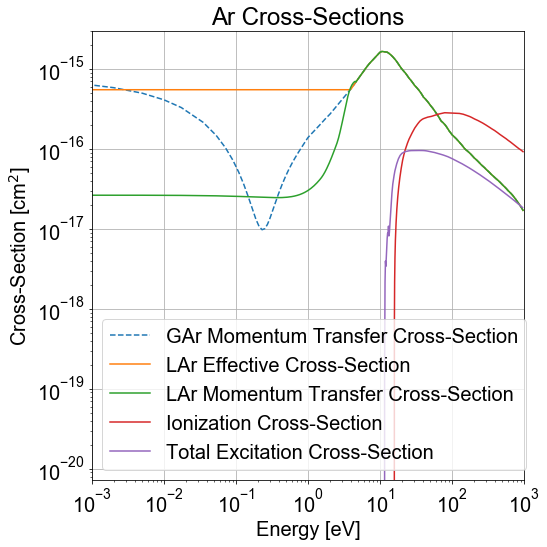

In [4]:
database = 'Biagi'

eV_min = 1e-3
eV_max = 9.5e2
eV_steps = 1000

# Low eV energy-independent LAr cross-sections that merge with the (single) momentum-transfer GAr cross-section at several eV (see Wojcik and Tachiya)
def liquid_sigma_e(eV, gas_sigma_p):
    if eV < 3.85:
        return 5.5e-16
    return gas_sigma_p(eV)

def liquid_sigma_p(eV, S, gas_sigma_p):
    if eV < 4.6:
        return S(eV) * 5.5e-16
    return gas_sigma_p(eV)

eV_list = np.logspace(np.log10(eV_min), np.log10(eV_max), eV_steps)

sigma_p_eVs, sigma_p = np.loadtxt(f'../preprocessing/cross-sections/{database}/momentum_xsec.txt', unpack=True)  # m^2
sigma_p *= 1e4                                                                                                   # to cm^2
sigma_p_func = interpolate.interp1d(sigma_p_eVs, sigma_p, kind='slinear', fill_value=(0., 0.), bounds_error=False)

sigma_i_eVs, sigma_i = np.loadtxt(f'../preprocessing/cross-sections/{database}/ionization_xsec.txt', unpack=True) # m^2
sigma_i *= 1e4                                                                                                    # to cm^2  
sigma_i_func = interpolate.interp1d(sigma_i_eVs, sigma_i, kind='slinear', fill_value=(0., 0.), bounds_error=False)

# S is the structure factor of LAr (see Wojcik and Tachiya)
S_eVs = np.array([0, 1, 2, 3, 4, 5, 6, 7])
S = np.array([0.048, 0.055, 0.125, 0.4, 1.115, 1.29, 1.16, 1.01])
S_func = interpolate.interp1d(S_eVs, S, kind='quadratic', fill_value=(0.048, 1), bounds_error=False)

final_sigma_e = np.vectorize(lambda eV: liquid_sigma_e(eV, sigma_p_func))
final_sigma_p = np.vectorize(lambda eV: liquid_sigma_p(eV, S_func, sigma_p_func))

file_list = []
avgs = np.full(4, 0.)

for ex_level in [11, 13, 14, 15]:
    file_list.append(glob.glob(f'../preprocessing/cross-sections/{database}/{ex_level}/excite_xsec_*.txt'))

sigma_ex = np.full((4, eV_steps), 0.)
sigma_ex_tot = np.zeros(eV_steps)

for k, file_group in enumerate(file_list):
    for file in file_group:
        x_temp, y_temp = np.loadtxt(file, unpack=True)
        interp_func = interpolate.interp1d(x_temp, y_temp, kind='slinear', fill_value=(0., 0.), bounds_error=False)
        avgs[k] += float(re.search(r'\d*\.\d*', file[-20:])[0])
        sigma_ex[k] += interp_func(eV_list) * 1e4
        sigma_ex_tot += interp_func(eV_list) * 1e4
    avgs[k] /= len(file_group)

# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'sans-serif'
# fig = plt.figure(figsize=(12, 8))

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig = plt.figure(figsize=(8, 8))

plt.plot(sigma_p_eVs, sigma_p, '--', label='GAr Momentum Transfer Cross-Section')
plt.plot(sigma_p_eVs, final_sigma_e(sigma_p_eVs), label='LAr Effective Cross-Section')
plt.plot(sigma_p_eVs, final_sigma_p(sigma_p_eVs), label='LAr Momentum Transfer Cross-Section')
plt.plot(sigma_i_eVs, sigma_i, label='Ionization Cross-Section')
plt.plot(eV_list, sigma_ex_tot, label='Total Excitation Cross-Section')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy [eV]')
plt.ylabel('Cross-Section [cm$^2$]')

plt.xlim(1e-3, 1e3)

plt.title('Ar Cross-Sections')

plt.grid()
plt.tight_layout()
# plt.show()

plt.savefig('x_secs.pdf', bbox_inches='tight')

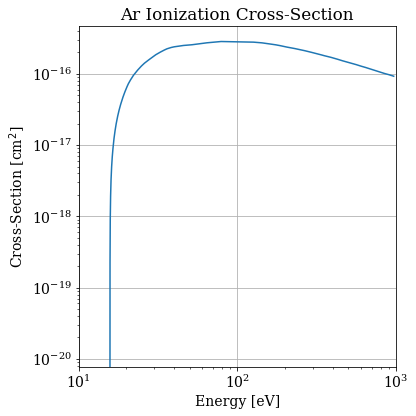

In [8]:
# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

plt.plot(sigma_i_eVs, sigma_i)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy [eV]')
plt.ylabel('Cross-Section [cm$^2$]')

plt.xlim(1e1, 1e3)

plt.title('Ar Ionization Cross-Section')

plt.grid()
plt.tight_layout()
plt.show()

# plt.savefig('ion_x_sec.pdf', bbox_inches='tight')